# Alternate Solve Methods (Scipy and Petsc)
Here we look at different ways of solving PDEs using external
packages and python functionality.
Different linear algebra backends can be accessed by changing setting the
`storage` parameter during construction of the discrete space. All
discrete functions and operators/schemes based on this space will then
use this backend. Available backends are `fem,istl,petsc`. The default is
`fem` which uses simple data structures and linear solvers implemented in
the `dune-fem` package. The simplicity of the data structure makes it
possible to use the buffer protocol to seamlessly move between C++ and
Numpy/Scipy data structures on the python side. A degrees of freedom
vector (dof vector) can be retrieved # from a discrete function over the
`fem` space by using the `as_numpy` method. Similar methods are available
for the other storages, i.e., `as_istl,as_petsc`. The same methods are
also available to retrieve the underlying matrix structures of linear
operators.

We will revisit the nonlinear time dependent problem studied in the
introduction which after discretizing in time had the variational formulation
\begin{equation}
\begin{split}
\int_{\Omega} \frac{u^{n+1}-u^n}{\Delta t} \varphi
+ \frac{1}{2}K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla \varphi \
+ \frac{1}{2}K(\nabla u^n) \nabla u^n \cdot \nabla \varphi v\ dx \\
- \int_{\Omega} \frac{1}{2}(f(x,t^n)+f(x,t^n+\Delta t) \varphi\ dx
- \int_{\partial \Omega} \frac{1}{2}(g(x,t^n)+g(x,t^n+\Delta t)) v\ ds
= 0.
\end{split}
\end{equation}
on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution
is given by
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
The following code was described in the introduction:

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math, sys, io

from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem.function import gridFunction, cppFunction, integrate, uflFunction
from dune.ufl import DirichletBC, Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate, FacetNormal, \
                dx, ds, div, grad, dot, inner, sqrt, exp, sin

gridView = leafGridView([0, 0], [1, 1], [4, 4])
space = solutionSpace(gridView, order=2)

x = SpatialCoordinate(space)
initial = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
exact   = lambda t: exp(-2*t)*(initial - 1) + 1

u_h   = space.interpolate(initial, name='u_h')
u_h_n = u_h.copy(name="previous")

u = TrialFunction(space)
v = TestFunction(space)
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time

abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
a = ( dot((u - u_h_n)/dt, v) \
    + 0.5*dot(K(u)*grad(u), grad(v)) \
    + 0.5*dot(K(u_h_n)*grad(u_h_n), grad(v)) ) * dx

f = lambda s: -2*exp(-2*s)*(initial - 1) - div( K(exact(s))*grad(exact(s)) )
g = lambda s: K(exact(s))*grad(exact(s))
n = FacetNormal(space)
b = 0.5*(f(t)+f(t+dt))*v*dx + 0.5*dot(g(t)+g(t+dt),n)*v*ds

scheme = solutionScheme(a == b, solver='cg')

endTime    = 0.25
exact_end  = exact(endTime)
l2error = uflFunction(gridView, name="l2error", order=u_h.space.order, ufl=dot(u_h - exact_end, u_h - exact_end))
h1error = uflFunction(gridView, name="h1error", order=u_h.space.order, ufl=dot(grad(u_h - exact_end), grad(u_h - exact_end)))

We define a function to evolve the solution from time 0 to the end time.
The first argument is a class with a `solve` method that moves the
solution from one time level to the next - i.e., solves for $u^{n+1}$
given $u^n$:

In [2]:
def evolve(scheme, u_h, u_h_n, endTime):
    time = 0
    while time < (endTime - 1e-6):
        scheme.model.t = time
        u_h_n.assign(u_h)
        scheme.solve(target=u_h)
        time += scheme.model.dt

We can simply use the `scheme` in this function to produce the solution
at the final time. We combine this with a loop to compute the error over
two grids and estimate the convergence rate:

Forchheimer: step: 0 , size: 16
	 | u_h - u | = 1.30293e-04 , eoc = -
	 | grad(uh - u) | = 3.99906e-03 , eoc = -


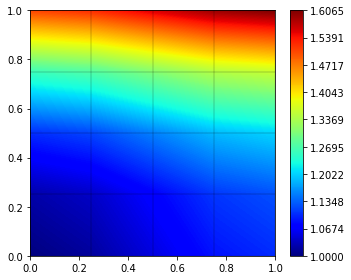

Forchheimer: step: 1 , size: 64
	 | u_h - u | = 1.61440e-05 , eoc = 3.01
	 | grad(uh - u) | = 9.99164e-04 , eoc = 2.0


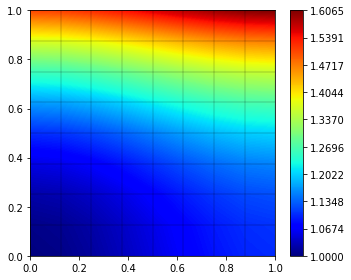

In [3]:
scheme.model.dt = 0.005

errors = 0,0
loops = 2
for eocLoop in range(loops):
    u_h.interpolate(initial)
    evolve(scheme, u_h, u_h_n, endTime)
    errors_old = errors
    errors = [sqrt(e) for e in integrate(gridView, [l2error,h1error], order=5)]
    if eocLoop == 0:
        eocs = ['-','-']
    else:
        eocs = [ round(math.log(e/e_old)/math.log(0.5),2) \
                 for e,e_old in zip(errors,errors_old) ]
    print('Forchheimer: step:', eocLoop, ', size:', gridView.size(0))
    print('\t | u_h - u | =', '{:0.5e}'.format(errors[0]), ', eoc =', eocs[0])
    print('\t | grad(uh - u) | =', '{:0.5e}'.format(errors[1]), ', eoc =', eocs[1])
    u_h.plot()
    if eocLoop < loops-1:
        gridView.hierarchicalGrid.globalRefine(1)
        scheme.model.dt /= 2

## Using Scipy
We implement a simple Newton Krylov solver using a linear solver from
Scipy. We can use the `as_numpy` method to access the degrees of freedom as
Numpy vector based on the `python buffer protocol`. So no data is copied
and changes to the dofs made on the python side are automatically carried
over to the C++ side.
from Scipy.

In [4]:
from dune.fem.operator import linear as linearOperator
import numpy as np
from scipy.sparse.linalg import spsolve as solver
class Scheme:
  def __init__(self, scheme):
      self.model = scheme.model
      self.jacobian = linearOperator(scheme)

  def solve(self, target):
      # create a copy of target for the residual
      res = target.copy(name="residual")

      # extract numpy vectors from target and res
      sol_coeff = target.as_numpy
      res_coeff = res.as_numpy

      n = 0
      while True:
          scheme(target, res)
          absF = math.sqrt( np.dot(res_coeff,res_coeff) )
          if absF < 1e-10:
              break
          scheme.jacobian(target,self.jacobian)
          sol_coeff -= solver(self.jacobian.as_numpy, res_coeff)
          n += 1

scheme_cls = Scheme(scheme)

u_h.interpolate(initial)                # reset u_h to initial
evolve(scheme_cls, u_h, u_h_n, endTime)
error = u_h - exact_end
print("Forchheimer(numpy) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
  *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Forchheimer(numpy) size:  64 L^2, H^1 error: 1.61699e-05, 9.99162e-04


Using a non linear solver from the Scipy package

In [5]:
from scipy.optimize import newton_krylov
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as solver

class Scheme2:
    def __init__(self, scheme):
        self.scheme = scheme
        self.model = scheme.model
        self.res = u_h.copy(name="residual")

    # non linear function
    def f(self, x_coeff):
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = space.function("tmp", dofVector=x_coeff)
        scheme(x, self.res)
        return self.res.as_numpy

    # class for the derivative DS of S
    class Df(LinearOperator):
        def __init__(self, x_coeff):
            self.shape = (x_coeff.shape[0], x_coeff.shape[0])
            self.dtype = x_coeff.dtype
            x = space.function("tmp", dofVector=x_coeff)
            self.jacobian = linearOperator(scheme, ubar=x)
        # reassemble the matrix DF(u) given a DoF vector for u
        def update(self, x_coeff, f):
            x = space.function("tmp", dofVector=x_coeff)
            scheme.jacobian(x, self.jacobian)
        # compute DS(u)^{-1}x for a given DoF vector x
        def _matvec(self, x_coeff):
            return solver(self.jacobian.as_numpy, x_coeff, tol=1e-10)[0]

    def solve(self, target):
        sol_coeff = target.as_numpy
        # call the newton krylov solver from scipy
        sol_coeff[:] = newton_krylov(self.f, sol_coeff,
                    verbose=0, f_tol=1e-8,
                    inner_M=self.Df(sol_coeff))

scheme2_cls = Scheme2(scheme)
u_h.interpolate(initial)
evolve(scheme2_cls, u_h, u_h_n, endTime)
error = u_h - exact_end
print("Forchheimer(scipy) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
  *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Forchheimer(scipy) size:  64 L^2, H^1 error: 1.61699e-05, 9.99162e-04


## Using Petsc and Petsc4Py
Switching to a storage based on the PETSc solver package and solving the
system using the dune-fem bindings

In [6]:
from dune.generator import ConfigurationError
try:
    import petsc4py
    petsc4py.init(sys.argv)
    from petsc4py import PETSc
    spacePetsc = solutionSpace(gridView, order=2, storage='petsc')
except ModuleNotFoundError:
    print("petsc4py not found: skipping example")
    print("petsc4py module not found so skipping example - ignored")
    petsc4py = None
except ConfigurationError:
    print("petsc4py found but petsc was not found during configuration of dune")
    petsc4py = None
    pass

if petsc4py is not None:
    # first we will use the petsc solver available in the `dune-fem` package
    # (using the sor preconditioner)
    schemePetsc = solutionScheme(a == b, space=spacePetsc,
                    parameters={"linear.preconditioning.method":"sor"})
    schemePetsc.model.dt = scheme.model.dt
    u_h = spacePetsc.interpolate(initial, name='u_h')
    u_h_n = u_h.copy(name="previous")
    evolve(schemePetsc, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))
else:
    print("petsc module not found so skipping example - ignored")
    spacePetsc = None
    pass

petsc4py found but petsc was not found during configuration of dune
petsc module not found so skipping example - ignored


Implementing a Newton Krylov solver using the binding provided by petsc4py

__Note__: this is not working at the moment!

In [7]:
if 0: # petsc4py is not None and spacePetsc is not None:
    class Scheme3:
      def __init__(self, scheme):
          self.model = scheme.model
          self.jacobian = linearOperator(scheme)
          self.ksp = PETSc.KSP()
          self.ksp.create(PETSc.COMM_WORLD)
          # use conjugate gradients method
          self.ksp.setType("cg")
          # and incomplete Cholesky
          self.ksp.getPC().setType(None) # "icc")
          self.ksp.setOperators(self.jacobian.as_petsc)
          self.ksp.setFromOptions()
      def solve(self, target):
          res = target.copy(name="residual")
          sol_coeff = target.as_petsc
          res_coeff = res.as_petsc
          n = 0
          while True:
              schemePetsc(target, res)
              absF = math.sqrt( res_coeff.dot(res_coeff) )
              if absF < 1e-10:
                  break
              schemePetsc.jacobian(target, self.jacobian)
              self.ksp.solve(res_coeff, res_coeff)
              sol_coeff -= res_coeff
              n += 1

    u_h.interpolate(initial)
    scheme3_cls = Scheme3(schemePetsc)
    evolve(scheme3_cls, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Using the petsc4py bindings for the non linear KSP solvers from PETSc
__Note__: this is not working at the moment!

In [8]:
if 0: # petsc4py is not None and spacePetsc is not None:
    class Scheme4:
        def __init__(self, scheme):
            self.model = scheme.model
            self.res = scheme.space.interpolate([0],name="residual")
            self.scheme = scheme
            self.jacobian = linearOperator(self.scheme)
            self.snes = PETSc.SNES().create()
            self.snes.setFunction(self.f, self.res.as_petsc.duplicate())
            self.snes.setUseMF(False)
            self.snes.setJacobian(self.Df, self.jacobian.as_petsc, self.jacobian.as_petsc)
            self.snes.getKSP().setType("cg")
            self.snes.setFromOptions()

        def f(self, snes, x, f):
            # setup discrete function using the provide petsc vectors
            inDF = self.scheme.space.function("tmp",dofVector=x)
            outDF = self.scheme.space.function("tmp",dofVector=f)
            self.scheme(inDF,outDF)

        def Df(self, snes, x, m, b):
            inDF = self.scheme.space.function("tmp",dofVector=x)
            self.scheme.jacobian(inDF, self.jacobian)
            return PETSc.Mat.Structure.SAME_NONZERO_PATTERN

        def solve(self, target):
            sol_coeff = target.as_petsc
            self.res.clear()
            self.snes.solve(self.res.as_petsc, sol_coeff)

    u_h.interpolate(initial)
    scheme4_cls = Scheme4(schemePetsc)
    evolve(scheme4_cls, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc4py) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))